In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from scipy import interpolate

from astropy import constants as const
from astropy import units as u

import extinction

from plotting_spectra import *

#plt.style.use('dark_background')

rc_params = {
    'lines.linewidth': 2,  # Set line width to 2 points
    'font.family': 'STIXGeneral',  # Set color cycle for axes
    'ytick.direction': 'in',  # Set figure size in inches
    'xtick.direction': 'in',  # Set default font family
}

plt.rcParams.update(rc_params)

In [2]:
# Here the lightcurves are loaded
lightcurves_alercextns = pd.read_pickle('./data/lightcurves/lcs_transients_20240517.pkl')
#lightcurves_alercextns

In [3]:
# Load all spectra info, metadata and data.
spectra_metadata = pd.read_csv('wiserep_spectra_metadata.csv', low_memory=False)
spectra_data     = pd.read_pickle('spectra_ALeRCE20240801_x_wisrep_20240622.pkl')

In [4]:
spectra_data.columns

Index(['oid', 'snname', 'instrument', 'mjd', 'lambda_grid_min',
       'lambda_grid_max', 'nlambda_grid', 'lambda_data_min', 'lambda_data_max',
       'flux_lambda', 'flux_lambda_smooth', 'e_flux_lambda'],
      dtype='object')

In [5]:
#CSP revisar estos espectros

In [6]:
spectra_metadata.columns

Index(['Obj. ID', 'IAU name', 'Internal name/s', 'Obj. RA', 'Obj. DEC',
       'Obj. Type', 'Redshift', 'Spec. ID', 'Obs-date', 'JD', 'Phase (days)',
       'From', 'Telescope', 'Instrument', 'Observer/s', 'Reducer/s',
       'Source group', 'Public', 'Associated groups', 'End prop. period',
       'Ascii file', 'Fits file', 'Spec. type', 'Spec. quality',
       'Extinction-Corrected', 'WL Medium', 'WL Units',
       'Flux Unit Coefficient', 'Spec. units', 'Flux Calibrated By',
       'Exp-time', 'Aperture (slit)', 'HA', 'Airmass', 'Dichroic', 'Grism',
       'Grating', 'Blaze', 'Lambda-min', 'Lambda-max', 'Del-Lambda', 'Contrib',
       'Publish', 'Remarks', 'Created by', 'Creation date'],
      dtype='object')

In [7]:
# Ver si los high, low, medium

In [8]:
spectra_metadata['Spec. quality'].value_counts()

Spec. quality
High      5671
Low       3125
Medium    2725
Name: count, dtype: int64

In [9]:
spectra_metadata[spectra_metadata['IAU name'] == 'SN 2019jyn']['Spec. quality'].value_counts()

Spec. quality
Medium    1
Name: count, dtype: int64

In [10]:
spectra_metadata['IAU name']

0          SN 1999Z
1          SN 1999Z
2          SN 1999Z
3          SN 1999Z
4          SN 1999Z
            ...    
46446    SN 2016hhv
46447    SN 2016hhv
46448    SN 2016hht
46449    SN 2016hhj
46450    SN 2016hhj
Name: IAU name, Length: 46451, dtype: object

In [140]:
spectra_metadata['IAU name'] = spectra_metadata['IAU name'].str.replace(' ', '')
spectra_metadata['IAU name']

0          SN1999Z
1          SN1999Z
2          SN1999Z
3          SN1999Z
4          SN1999Z
           ...    
46446    SN2016hhv
46447    SN2016hhv
46448    SN2016hht
46449    SN2016hhj
46450    SN2016hhj
Name: IAU name, Length: 46451, dtype: object

In [144]:
# List of supernova names with less than 5 spectra
supernovae_few_spectra = spectra_data['snname'].value_counts()[spectra_data['snname'].value_counts() >= 2].index
high_value_supernovae = spectra_metadata[spectra_metadata['Spec. quality'] == 'High']['IAU name']


supernoave_list_filter = list(set(supernovae_few_spectra) & set(high_value_supernovae))
supernoave_list_filter
# usar el percentil 10 de los minimos
# Usar el percentil 90 de las maximos

#spectra_data.lambda_data_min.quantile(0.1)

126

In [ ]:
# Erorr de como se toma la fotometria

In [117]:
#spectrum = spectra_data[spectra_data.snname == np.random.choice(spectra_data.snname.unique())]
spectrum = spectra_data[spectra_data.snname.isin(supernoave_list_filter)]
spectrum = spectrum[spectrum.oid.notna()]
#spectrum = spectra_data[spectra_data.snname == 'SN2021ik']
spectrum = spectrum[spectrum.snname == np.random.choice(spectrum.snname.unique())]
spectrum

,oid,snname,instrument,mjd,lambda_grid_min,lambda_grid_max,nlambda_grid,lambda_data_min,lambda_data_max,flux_lambda,flux_lambda_smooth,e_flux_lambda
16461,ZTF20acqzjqz,SN2020aabz,P60_SEDM,59170.445278,3206.34,10915.01,1838,3776.700000,9223.300000,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
16462,ZTF20acqzjqz,SN2020aabz,ESO-NTT_EFOSC2-NTT,59174.171733,3206.34,10915.01,1838,3650.047852,9245.227452,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[2.6385780009074255e-17, 2.6762200182763875e-1..."


In [118]:
spectrum.mjd.value_counts()

mjd
59170.445278    1
59174.171733    1
Name: count, dtype: int64

16461    3.50601
Name: lambda_grid_min, dtype: float64
16462    3.50601
Name: lambda_grid_min, dtype: float64


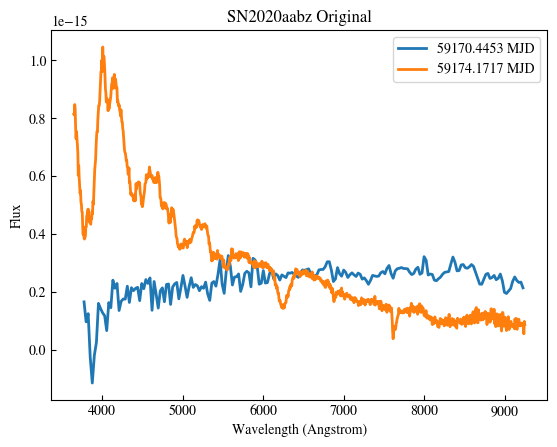

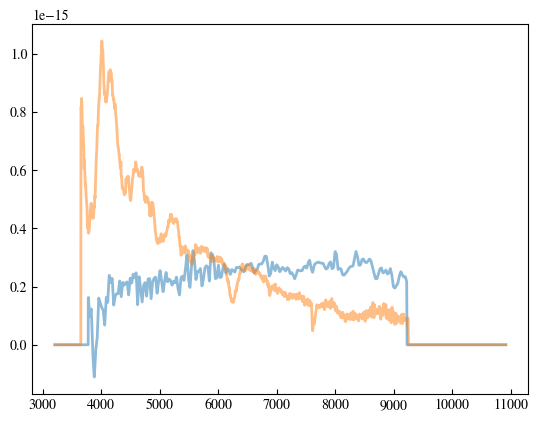

In [119]:
sn_name=spectrum.snname.unique()[0]
fig, ax = plt.subplots()
raw_spectra = pd.read_csv(f'./data/spectra_wiserep/{sn_name}.dat')
for group_name, group in raw_spectra.groupby('mjd'):
    ax.plot(group['lambda'].to_numpy(), group.flux_lambda.to_numpy(), label=f'{group_name:.4f} MJD')
ax.set_title(f'{sn_name} Original')# MJD: {group_name:.3f}')
ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel('Flux')
ax.legend()

fig, ax = plt.subplots()
for group_name, group in spectrum.groupby('mjd'):
   print(np.log10(group.lambda_grid_min))
   x = np.logspace(np.log10(group.lambda_grid_min), np.log10(group.lambda_grid_max),group.nlambda_grid.values[0])
   y = np.array(group.flux_lambda)[0]
   y = np.nan_to_num(y,nan=0.0)
   ax.plot(x, y, label=f'{group_name:.4f} MJD',alpha=0.5)

#plot_spectra(spectrum, use_lambda_grid=True, sn_name=sn_name)

In [120]:
objective_ligtcurve = lightcurves_alercextns[lightcurves_alercextns.oid == spectrum.oid.unique()[0]]

In [121]:
wavelength_lsst = {'u':[3206.34, 4081.51], 'g':[3876.02, 5665.33], 'r':[5377.19, 7055.16],
                   'i':[6765.77, 8325.05], 'z':[8035.39, 9375.47], 'y':[9089.07, 10915.01]}

wavelength_ztf ={'g':[3676.00, 5613.82], 'r':[5497.60, 7394.40], 'i':[6870.97, 8964.61],}

ztf_sv_files  = [file for file in os.listdir('./data/') if 'Palomar' in file]
lsst_sv_files = [file for file in os.listdir('./data/') if 'LSST' in file]

ztf_sv_dict  = {file.split('.')[1]: np.loadtxt(fname=f'./data/{file}') for file in ztf_sv_files}
lsst_sv_dict = {file.split('.')[1]: np.loadtxt(fname=f'./data/{file}') for file in lsst_sv_files}

In [122]:
#grouped = raw_spectra.groupby('mjd').agg(list).reset_index()
# #grouped
# spectrum = raw_spectra.groupby('mjd').agg(list).reset_index()
# spectrum

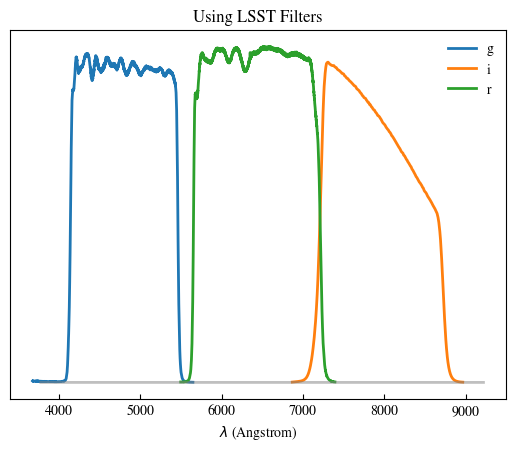

In [123]:
idx_spec = 0
fig, ax = plt.subplots()
#x_spectrum = np.array(spectrum.iloc[idx_spec]['lambda_'])

x_spectrum = np.logspace(np.log10(spectrum.iloc[idx_spec].lambda_grid_min),np.log10(spectrum.iloc[idx_spec].lambda_grid_max),len(spectrum.iloc[idx_spec].flux_lambda))
y_spectrum = np.array((spectrum.iloc[idx_spec]['flux_lambda'])) 

for band, sv in ztf_sv_dict.items():
    x, y = zip(*ztf_sv_dict[band])
    ax.plot(x,y,label=f'{band}')
ax.plot(x_spectrum, y_spectrum, alpha = 0.5, color='gray')
ax.set_xlabel(r'$\lambda$ (Angstrom)')
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_title('Using LSST Filters')
ax.legend(frameon=False)

plt.show()

In [124]:
def simple_integration(x:list[float],y:list[float],delta_x:list[float]) -> float:
    y = np.nan_to_num(y, nan=0.0)

    #if delta_x == None:
    #    delta_x = x[i] 

    integral = 0
    for i in range(len(delta_x)-1):
        integral += (y[i] + y[i+1]) * delta_x[i] / 2.0
    return integral

In [125]:
def obtain_magnitude_flux(spectrum:pd.DataFrame,instrument:str) -> dict:

    CSPEED = 3e8 # m/s

    if instrument == 'ztf':
        tranmision_dict = ztf_sv_dict
    elif instrument ==  'lsst':
        tranmision_dict = lsst_sv_dict

    x_spectrum = np.logspace(np.log10(spectrum.lambda_grid_min),np.log10(spectrum.lambda_data_max),spectrum.nlambda_grid)
    y_spectrum = np.array(spectrum.flux_lambda)
    f = interpolate.interp1d(x_spectrum,y_spectrum, fill_value=np.nan, bounds_error=False)
    #print(len(y_spectrum), len(x_spectrum))

    mags = {}   
    for band, s_wave in tranmision_dict.items():
        band, s_wave = band,s_wave
        wave, s_wave = zip(*tranmision_dict[band])
        wave, s_wave = np.array(wave), np.array(s_wave)

        #condition = np.where((min(wave) < x_spectrum) & (max(wave) > x_spectrum))
        #x = x_spectrum[condition]
        #y = y_spectrum[condition]
        
        flux_wave = f(wave)
        #flux_wave = y_spectrum

        log_nu = -np.log(wave)                           # Obtaining log_nu in lambda termns
        f_nu   = (wave**2/(CSPEED*1e10)) * flux_wave # Obtaining f_nu in lambda termns
        s_nu   = s_wave 

        num = np.trapz(f_nu*s_nu, dx=log_nu[:-1])
        den = np.trapz(s_nu, dx=log_nu[:-1])
        #print(f'Band = {band}')
        #print(f'num={num}, den={den}')
        num_test = simple_integration(wave,f_nu*s_nu, log_nu)
        den_test = simple_integration(wave,s_nu, log_nu)
        #print(f'num_test={num_test}, den_test={den_test}')
        m = -2.5 * np.log10(num_test/den_test) - 48.60
        #m = -2.5 * np.log10(num/den) - 48.60
        mags.update({band:m})
    print(mags)
    return mags

{'g': 18.277799563888813, 'i': 17.748730120419545, 'r': 17.471451881948376}
{'g': 17.656752644827257, 'i': 18.70817324199951, 'r': 17.97459622132505}


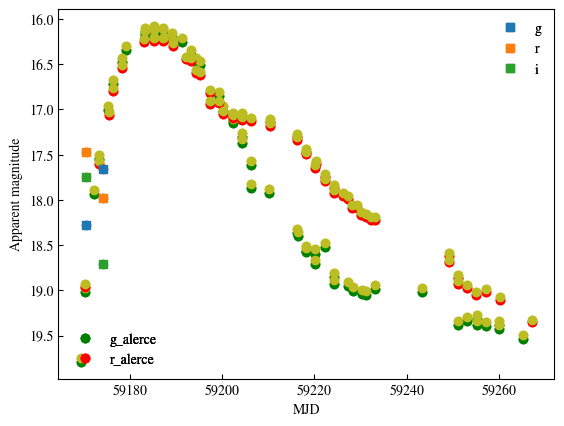

In [126]:
instrument = 'ztf'
if instrument == 'ztf':
    colors = ['C0','C1','C2']
    bands = ['g','r','i']
else:
    colors = ['C0','C1','C2','C3','C4','C5']
    bands = ['u','g','r','i','z','y']

wave = np.array([4746.48, 6366.38])

fig, ax = plt.subplots()
for _, row in spectrum.iterrows():
    for group_name, group in objective_ligtcurve.groupby('fid'):
        color = 'green' if group_name == 1 else 'red'
        extinction_correction = extinction.ccm89(wave, 0.0375, 3.1)[0] if group_name == 1 else extinction.ccm89(wave, 0.0375, 3.1)[1]
        ax.scatter(x=group.mjd, y=group.magpsf, color=color)
        ax.scatter(x=group.mjd, y=group.magpsf - extinction_correction, color='C8')
        
    # This calculate the magnitude of the spectrum based on
    # the integration of the flux
    
    try:
        magnitude_integrated = obtain_magnitude_flux(spectrum=row, instrument=instrument)
    except:
        continue
    for bandapass, magnitude in magnitude_integrated.items():
        ax.scatter(row.mjd,magnitude)
        if instrument == 'ztf':
            color = colors[0] if 'g' in bandapass else colors[1] if 'r' in bandapass else colors[2]
            #label = 
            ax.scatter(row.mjd,magnitude, marker='s',color = color)
        else: 
            color = colors[0] if 'u' in bandapass else colors[1] if 'g' in bandapass else colors[2] if 'r' in bandapass else colors[3] if 'i' in bandapass else colors[4] if 'z' in bandapass else colors[5]
            ax.scatter(row.mjd,magnitude, marker='s',color = color)
    
    handles = [mlines.Line2D([], [], c=color, marker='s',ls='') for color in colors]
    leg1 = ax.legend(handles, bands, loc='upper right',frameon=False)
    ax.add_artist(leg1)
    handles = [mlines.Line2D([], [], c=color, marker='o',ls='') for color in ['g', 'r']]
    leg2 = ax.legend(handles, ['g_alerce', 'r_alerce'], loc='lower left',frameon=False)
    ax.add_artist(leg2)

    ax.yaxis.set_inverted(True)
    ax.set_xlabel('MJD')
    ax.set_ylabel('Apparent magnitude')
    #ax.set_title(f'Light Curve {oid}')

In [127]:
# Agregar el 
# Verificar si estan fotocalibrados

In [128]:
redshift = spectra_metadata[spectra_metadata['IAU name'] == spectrum.snname.unique()[0]]['Redshift'].iloc[0]

{'g': 18.277799563888813, 'i': 17.748730120419545, 'r': 17.471451881948376}
{'g': 17.656752644827257, 'i': 18.70817324199951, 'r': 17.97459622132505}


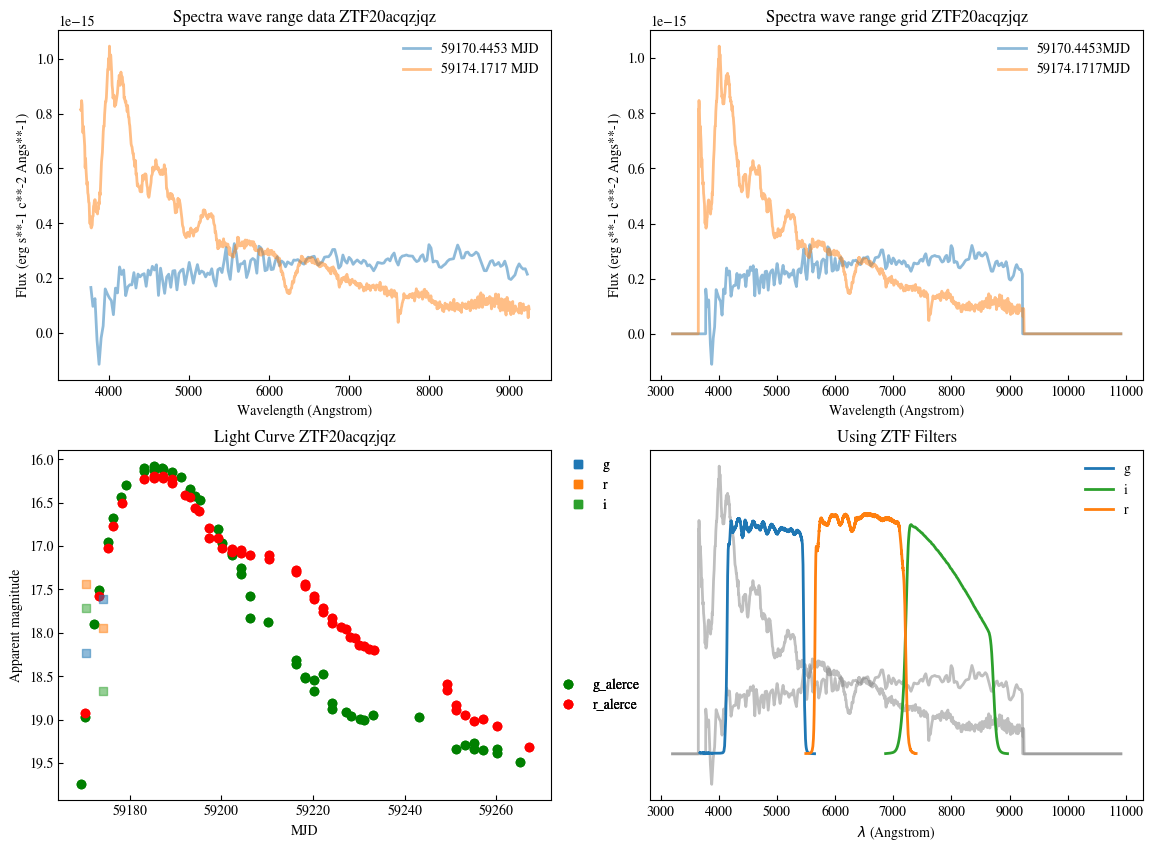

In [129]:
instrument = 'ztf'
if instrument == 'ztf':
    colors = ['C0','C1','C2']
    bands = ['g','r','i']
else:
    colors = ['C0','C1','C2','C3','C4','C5']
    bands = ['u','g','r','i','z','y']

wave = np.array([4746.48, 6366.38])

sn_name = spectrum.snname.unique()[0]
oid     = spectrum.oid.unique()[0]
raw_spectra = pd.read_csv(f'./data/spectra_wiserep/{sn_name}.dat')

fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(nrows=2,ncols=2, figsize=(14, 10))

for group_name, group in raw_spectra.groupby('mjd'):
    ax0.plot(group['lambda'].to_numpy(), group.flux_lambda.to_numpy(), label=f'{group_name:.4f} MJD', alpha=0.5)
ax0.set_title(f'{sn_name} Original')# MJD: {group_name:.3f}')
ax0.set_xlabel('Wavelength (Angstrom)')
ax0.set_ylabel('Flux (erg s**-1 c**-2 Angs**-1)')
ax0.set_title(f'Spectra wave range data {oid}')
ax0.legend(frameon=False)

for _, row in spectrum.iterrows():

    x_spectrum_grid = np.logspace(np.log10(row.lambda_grid_min),np.log10(row.lambda_grid_max), row.nlambda_grid)
    y_spectrum_grid = np.nan_to_num(np.array(row.flux_lambda),nan=0.0)
    ax1.plot(x_spectrum_grid, y_spectrum_grid,label=f'{row.mjd:.4f}MJD', alpha=0.5)
    ax1.set_ylabel('Flux (erg s**-1 c**-2 Angs**-1)')
    ax1.set_xlabel('Wavelength (Angstrom)')
    ax1.set_title(f'Spectra wave range grid {oid}')
    ax1.legend(frameon=False)

    for group_name, group in objective_ligtcurve.groupby('fid'):
        color = 'green' if group_name == 1 else 'red'
        extinction_correction = extinction.ccm89(wave, 0.0375, 3.1)[0] if group_name == 1 else extinction.ccm89(wave, 0.0375, 3.1)[1]
        ax2.scatter(x=group.mjd, y=group.magpsf - extinction_correction, color=color)
        
    # This calculate the magnitude of the spectrum based on
    # the integration of the flux
    
    magnitude_integrated = obtain_magnitude_flux(spectrum=row, instrument=instrument)
    for bandapass, magnitude in magnitude_integrated.items():
        if instrument == 'ztf':
            color = colors[0] if 'g' in bandapass else colors[1] if 'r' in bandapass else colors[2]
            extinction_correction = extinction.ccm89(wave, 0.0375, 3.1)[0] if 'g' in bandapass else extinction.ccm89(wave, 0.0375, 3.1)[1]
            #label = 
            ax2.scatter(row.mjd,magnitude - extinction_correction, marker='s',color = color, alpha=0.5)
        else: 
            color = colors[0] if 'u' in bandapass else colors[1] if 'g' in bandapass else colors[2] if 'r' in bandapass else colors[3] if 'i' in bandapass else colors[4] if 'z' in bandapass else colors[5]
            ax2.scatter(row.mjd,magnitude, marker='s',color = color, alpha=0.5)
    
    handles = [mlines.Line2D([], [], c=color, marker='s',ls='') for color in colors]
    leg1 = ax2.legend(handles, bands, loc='center left', bbox_to_anchor=(1, 0.9),frameon=False)
    ax2.add_artist(leg1)
    handles = [mlines.Line2D([], [], c=color, marker='o',ls='') for color in ['g', 'r']]
    leg2 = ax2.legend(handles, ['g_alerce', 'r_alerce'], loc = 'center left', bbox_to_anchor=(0.98, 0.3),frameon=False)
    ax2.add_artist(leg2)

    ax2.yaxis.set_inverted(True)
    ax2.set_xlabel('MJD')
    ax2.set_ylabel('Apparent magnitude')
    ax2.set_title(f'Light Curve {oid}')

    ax3.plot(x_spectrum_grid, y_spectrum_grid *1e15, alpha = 0.5, color='gray')
for band, sv in ztf_sv_dict.items():
    color = 'C0' if band == 'g' else 'C1' if band == 'r' else 'C2'
    x, y = zip(*ztf_sv_dict[band])
    ax3.plot(x,y,label=f'{band}', color=color)
ax3.set_xlabel(r'$\lambda$ (Angstrom)')
ax3.set_yticklabels([])
ax3.set_yticks([])
ax3.set_title('Using ZTF Filters')
ax3.legend(frameon=False)
plt.show()

In [130]:
from astropy import units as u
from specutils.spectra import Spectrum1D
from specutils.fitting import fit_generic_continuum

In [131]:
spectrum_test = spectrum.iloc[0]
spectrum_test

oid                                                        ZTF20acqzjqz
snname                                                       SN2020aabz
instrument                                                     P60_SEDM
mjd                                                        59170.445278
lambda_grid_min                                                 3206.34
lambda_grid_max                                                10915.01
nlambda_grid                                                       1838
lambda_data_min                                                  3776.7
lambda_data_max                                                  9223.3
flux_lambda           [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
flux_lambda_smooth    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
e_flux_lambda         [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
Name: 16461, dtype: object

In [132]:
wavelength_spectrum_test = np.logspace(np.log10(spectrum_test.lambda_grid_min),np.log10(spectrum_test.lambda_grid_max), spectrum.nlambda_grid.values[0])
flux_spectrum_test_normalized = np.array(spectrum_test.flux_lambda)
#flux_spectrum_test_normalized = (np.array(spectrum_test.flux_lambda) - nparray(spectrum_test.flux_lambda_smooth))/np.array(spectrum_test.flux_lambda_smooth)
#flux_spectrum_test_normalized = np.nan_to_num(flux_spectrum_test_normalized,nan=0.0)

len(flux_spectrum_test_normalized), len(wavelength_spectrum_test)

(1838, 1838)

In [134]:
len(flux_spectrum_test_normalized), len(wavelength_spectrum_test)

(1838, 1838)

In [135]:
#flux_spectrum_test_normalized = (np.nan_to_num(np.array(spectrum_test.flux_lambda)) - np.nan_to_num(np.array(spectrum_test.flux_lambda_smooth)))
flux_spectrum_test_normalized = np.array(spectrum_test.flux_lambda) / max(np.nan_to_num(np.array(spectrum_test.flux_lambda)))
flux_spectrum_test_normalized[flux_spectrum_test_normalized < 0] = 0
#flux_spectrum_test_normalized = np.nan_to_num(flux_spectrum_test_normalized,nan=0.0)

valid_positions = ~np.isnan(flux_spectrum_test_normalized)
flux_spectrum_test_normalized = flux_spectrum_test_normalized[valid_positions]
wavelength_spectrum_test = wavelength_spectrum_test[valid_positions]

spectrum_fit = Spectrum1D(flux=flux_spectrum_test_normalized*(u.erg / u.s / u.cm**2 / u.AA), spectral_axis=wavelength_spectrum_test* u.AA)

In [136]:
g1_fit = fit_generic_continuum(spectrum_fit)
y_continuum_fitted = g1_fit(wavelength_spectrum_test*u.AA)

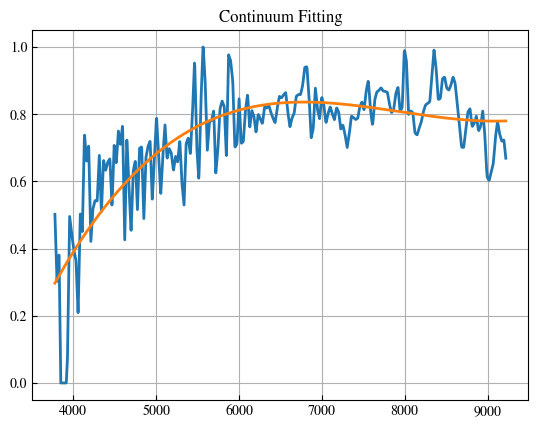

In [137]:
f, ax = plt.subplots()  
ax.plot(wavelength_spectrum_test, flux_spectrum_test_normalized)  
ax.plot(wavelength_spectrum_test, y_continuum_fitted)  
ax.set_title("Continuum Fitting")  
ax.grid(True)  

In [ ]:
# REstar y dividir el continuo para estar centrado en 0 que en centrado 1

In [138]:
spec_normalized = spectrum_fit / y_continuum_fitted

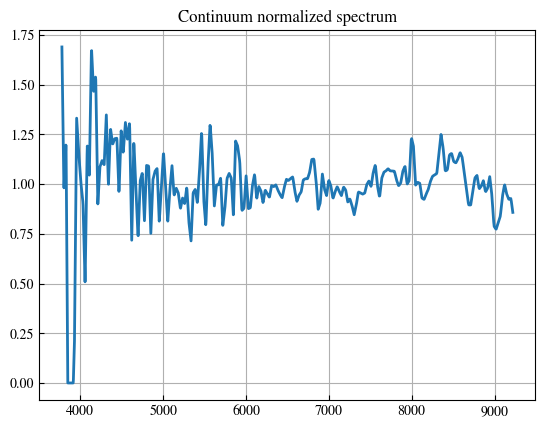

In [139]:
f, ax = plt.subplots()  
ax.plot(spec_normalized.spectral_axis, spec_normalized.flux)  
ax.set_title("Continuum normalized spectrum")  
ax.grid(True)  

Calcualte the magnitud

https://articles.adsabs.harvard.edu/pdf/1996AJ....111.1748F

In [116]:
def simple_integration(x:list[float],y:list[float],delta_x:list[float]) -> float:
    y = np.nan_to_num(y, nan=0.0)

    if delta_x == None:
        delta_x = x[i] 

    integral = 0
    for i in range(len(delta_x)-1):
        integral += (y[i] + y[i+1]) * delta_x[i] / 2.0
    return integral